# Goodfellow et al., 2014 - Replication

This Notebook aims at replicating the results of Goodfellow et al., 2014 paper "EXPLAINING AND HARNESSING ADVERSARIAL EXAMPLES" on the simple MNIST dataset and experimenting with the concept introduced there.

## Imports

In [24]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.models import resnet34 as Resnet

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from train_mnist import Net

## Constants

In [46]:
EPS = np.array([0, .05, .1, .15, .2, .25, .3], dtype=np.float32)
BATCH_SIZE = 1
DEVICE = torch.device('cpu')

SIMPLE_MODEL1 = 'trained_models/mnist_cnn_best_1672124664.pt'
SIMPLE_MODEL2 = 'trained_models/mnist_cnn_best_1672286365.pt'
RESNET_MODEL1 = 'trained_models/mnist_cnn_best_resnet_1672287085.pt'
RESNET_MODEL2 = 'trained_models/mnist_cnn_best_resnet_1672293597.pt'

AE_MODEL1 = 'trained_models/mnist_cnn_best_eps0.2_p0.3_1672896383.pt'
AER_MODEL1 = 'trained_models/mnist_cnn_best_replacement_eps0.2_p0.3_1672903222.pt'
REG_MODEL1 = 'trained_models/mnist_cnn_best_reg_alpha0.5_eps0.2_1672906865.pt'

In [3]:
# Load data
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST('./dataset', train=False, download=True, transform=transform)

test_kwargs = {'batch_size': BATCH_SIZE, 'shuffle':False}
test_loader = torch.utils.data.DataLoader(dataset, **test_kwargs)

## Experiments

### Basic experiment utils

The following code implements FSGM attack and compares it to naive approach with random noise.
Note that a more elaborate version of the method *fgsm_attack* is implemented in the fgsm.py file.

In [4]:
def fgsm_attack(image, epsilons, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign().repeat(epsilons.shape)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_images = image.repeat(epsilons.shape) + sign_data_grad * epsilons
    # Adding clipping to maintain [0,1] range
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    # Return the perturbed image
    return perturbed_images

In [22]:
def perform_exp(model, model2, test_loader):
    epsilons = EPS
    epsilons4d = epsilons.reshape((-1, 1, 1, 1))
    # Accuracy counter
    correct = np.zeros(epsilons.shape, dtype=np.int32)
    bl_correct = np.zeros(epsilons.shape, dtype=np.int32)
    adv_examples = [[] for _ in epsilons]

    # Loop over all examples in test set
    for data, target in test_loader:
        # Set requires_grad attribute of tensor which is important for attacking
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        # Zero all existing gradients
        model.zero_grad()

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Calculate gradients of model in backward pass
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilons4d, data_grad)
        
        # Re-classify the perturbed image
        if model2:
            outputs = model2(perturbed_data)
        else:
            outputs = model(perturbed_data)
            
        # Naive attack
        bl_noise = (torch.randint(1, data.shape) - 0.5).sign().repeat(epsilons4d.shape) * epsilons4d
        bl_data = torch.clamp(data.repeat(epsilons4d.shape) + bl_noise, 0, 1)
        
        # Re-classify the Naive attack image
        if model2:
            bl_outputs = model2(bl_data)
        else:
            bl_outputs = model(bl_data)

        # Check for success
        final_preds = outputs.max(1)[1]  # get the index of the max log-probability
        for i in range(len(epsilons)): 
            if final_preds[i].item() == target.item():
                correct[i] += 1
                # Special case for saving 0 epsilon examples
                if (epsilons[i] == 0) and (len(adv_examples[i]) < 5):
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples[i].append((init_pred.item(), final_preds[i].item(), adv_ex))
            else:
                # Save some adv examples for visualization later
                if len(adv_examples[i]) < 5:
                    adv_ex = perturbed_data[i].squeeze().detach().cpu().numpy()
                    adv_examples[i].append((init_pred.item(), final_preds[i].item(), adv_ex))
                
        bl_final_preds = bl_outputs.max(1)[1]  # get the index of the max log-probability
        for i in range(len(epsilons)):
            if bl_final_preds[i].item() == target.item():
                bl_correct[i] += 1 

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    
    # For naive approach
    bl_final_acc = bl_correct / float(len(test_loader))
    
    for i, epsilon in enumerate(epsilons):
        print(f'Epsilon: {epsilon: .2g}\tFGSM\tTest Accuracy = {correct[i]}/{len(test_loader)} = {final_acc[i]}')
        print(f'Epsilon: {epsilon: .2g}\tNaive\tTest Accuracy = {bl_correct[i]}/{len(test_loader)} = {bl_final_acc[i]}')

    # Return the accuracy and an adversarial example
    return final_acc, bl_final_acc, adv_examples

def analyze_errors(model, test_loader, epsilon):
    pred_mat = np.zeros((10, 10), dtype=np.int32)
    # Loop over all examples in test set
    for data, target in test_loader:
        # Set requires_grad attribute of tensor which is important for attacking
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        
        # Zero all existing gradients
        model.zero_grad()

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Calculate gradients of model in backward pass
        loss.backward()
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, np.array([[[[epsilon]]]], dtype=np.float32), data_grad)
        
        # Re-classify the perturbed image
        output = model(perturbed_data)
        final_pred = output.max(1)[1].item()
        
        pred_mat[target.item()][final_pred] += 1
    
    return pred_mat  

#### Visualization

In [29]:
def plot_acc_graph(accuracies, bl_accuracies):
    plt.figure(figsize=(5, 5))
    plt.plot(EPS, accuracies, '*-', label='FGSM')
    plt.plot(EPS, bl_accuracies, '^-', label='Naive')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title('Accuracy vs Epsilon')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_examples(examples):
    # Plot several examples of adversarial samples at each epsilon
    cnt = 0
    plt.figure(figsize=(8, 10))
    for i in range(len(EPS)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(EPS), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f'Eps: {EPS[i]: .2g}', fontsize=14)
            orig, adv, ex = examples[i][j]
            plt.title(f'{orig} -> {adv}')
            plt.imshow(ex, cmap='gray')
    plt.tight_layout()
    plt.show()
    
def plot_error_mat(error_mat):
    labels = np.arange(10)
    sns.heatmap(error_mat, annot=True, xticklabels=labels, yticklabels=labels, annot_kws={"fontsize":6})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

### Fast Gradient Sign Method

### *Experiment 1 - Basic FGSM*

How would a simple network (convolution -> FC -> FC) layer would perform against noise?

In [7]:
# Load first simple trained model
smodel1 = Net().to(DEVICE)
smodel1.load_state_dict(torch.load(SIMPLE_MODEL1))
_ = smodel1.eval()

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epsilon:  0	FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0	Naive	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0.05	FGSM	Test Accuracy = 9132/10000 = 0.9132
Epsilon:  0.05	Naive	Test Accuracy = 9879/10000 = 0.9879
Epsilon:  0.1	FGSM	Test Accuracy = 5834/10000 = 0.5834
Epsilon:  0.1	Naive	Test Accuracy = 9858/10000 = 0.9858
Epsilon:  0.15	FGSM	Test Accuracy = 2252/10000 = 0.2252
Epsilon:  0.15	Naive	Test Accuracy = 9813/10000 = 0.9813
Epsilon:  0.2	FGSM	Test Accuracy = 1347/10000 = 0.1347
Epsilon:  0.2	Naive	Test Accuracy = 9690/10000 = 0.969
Epsilon:  0.25	FGSM	Test Accuracy = 1175/10000 = 0.1175
Epsilon:  0.25	Naive	Test Accuracy = 9441/10000 = 0.9441
Epsilon:  0.3	FGSM	Test Accuracy = 1138/10000 = 0.1138
Epsilon:  0.3	Naive	Test Accuracy = 8712/10000 = 0.8712


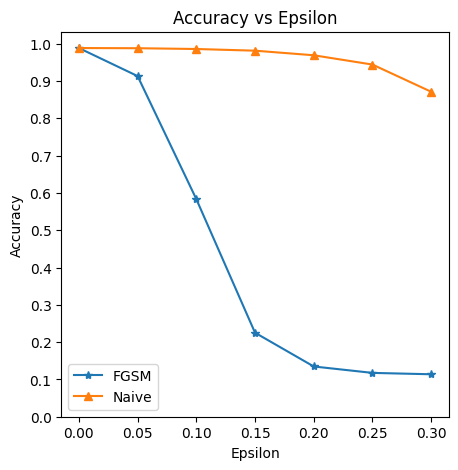

In [8]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

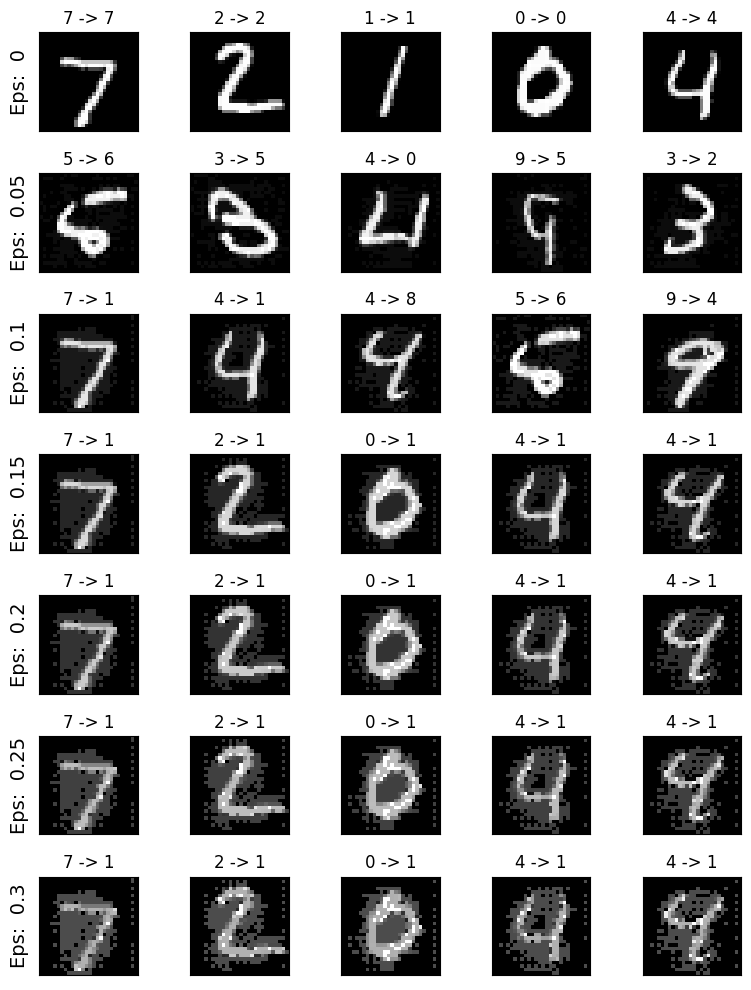

In [9]:
plot_examples(examples)

Random noise seem to affect performance relatively little while the engineered noise based on the FGSM lowers performance to chance level, without majorly affecting the images in the eyes of a human observer.

In [27]:
error_mat = analyze_errors(smodel1, test_loader, 0.15)

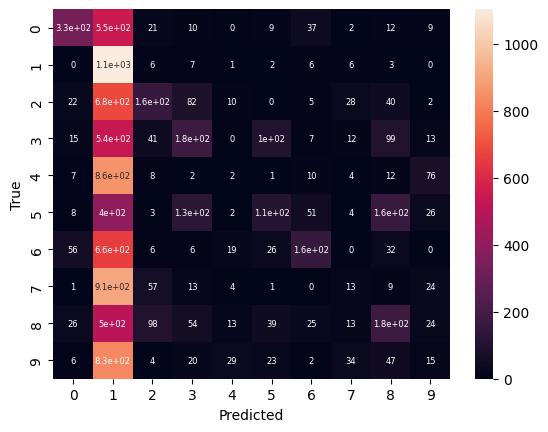

In [30]:
plot_error_mat(error_mat)

Based on the last plot, the adversarial noise pushes the predictions towards "1" with the exception of 0 which retains some accuracy. Note that this is with a moderate epsilon value of 0.15. As can be seen from the "Accuracy vs Epsilon" plot, for higher epsilon values the performance drops to chance level, which means that this adventage is too, lost (validated below).

In [ ]:
error_mat = analyze_errors(smodel1, test_loader, 0.25)
plot_error_mat(error_mat)

### Generalization

In this section the main observation of the "Why do adversarial exaples generalize" subsection. Here I chose different models, somewhat more inline with modern practices today utilizing the slightly newer Resnet34 model (concept presented in December of 2015) rather than shalllow networks of low complexity. On the other hand, comparisons about error type are not included as I find them not as critical in light of the last plot.

### *Experiment 2 - Generaliztion between similar architectures*

How would the generated noise generalize to a different network with a similar architecture?

In [10]:
# Load second simple trained model
smodel2 = Net().to(DEVICE)
smodel2.load_state_dict(torch.load(SIMPLE_MODEL2))
_ = smodel2.eval()

Epsilon:  0	FGSM	Test Accuracy = 9892/10000 = 0.9892
Epsilon:  0	Naive	Test Accuracy = 9892/10000 = 0.9892
Epsilon:  0.05	FGSM	Test Accuracy = 9544/10000 = 0.9544
Epsilon:  0.05	Naive	Test Accuracy = 9889/10000 = 0.9889
Epsilon:  0.1	FGSM	Test Accuracy = 7494/10000 = 0.7494
Epsilon:  0.1	Naive	Test Accuracy = 9872/10000 = 0.9872
Epsilon:  0.15	FGSM	Test Accuracy = 3543/10000 = 0.3543
Epsilon:  0.15	Naive	Test Accuracy = 9803/10000 = 0.9803
Epsilon:  0.2	FGSM	Test Accuracy = 1932/10000 = 0.1932
Epsilon:  0.2	Naive	Test Accuracy = 9609/10000 = 0.9609
Epsilon:  0.25	FGSM	Test Accuracy = 1484/10000 = 0.1484
Epsilon:  0.25	Naive	Test Accuracy = 8925/10000 = 0.8925
Epsilon:  0.3	FGSM	Test Accuracy = 1316/10000 = 0.1316
Epsilon:  0.3	Naive	Test Accuracy = 7149/10000 = 0.7149


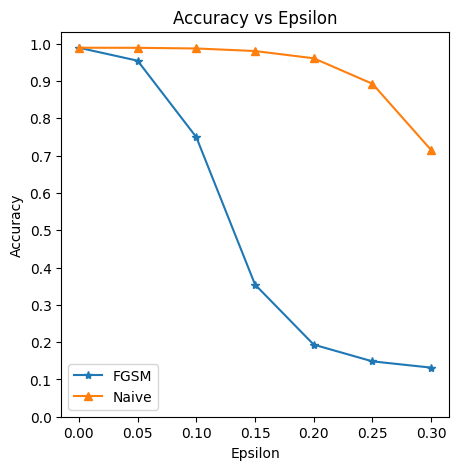

In [11]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, smodel2, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Generalization of the noise seems to be perfect.

### *Experiment 2.5 - Stronger network*

Checking resiliance of a deeper and more complex network (Resnet34) in a similar way to experiment 1.

In [12]:
# Load first resnet trained model
rmodel1 = Resnet().to(DEVICE)
rmodel1.load_state_dict(torch.load(RESNET_MODEL1))
_ = rmodel1.eval()

Epsilon:  0	FGSM	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0	Naive	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0.05	FGSM	Test Accuracy = 9563/10000 = 0.9563
Epsilon:  0.05	Naive	Test Accuracy = 9935/10000 = 0.9935
Epsilon:  0.1	FGSM	Test Accuracy = 8175/10000 = 0.8175
Epsilon:  0.1	Naive	Test Accuracy = 9927/10000 = 0.9927
Epsilon:  0.15	FGSM	Test Accuracy = 6036/10000 = 0.6036
Epsilon:  0.15	Naive	Test Accuracy = 9915/10000 = 0.9915
Epsilon:  0.2	FGSM	Test Accuracy = 4431/10000 = 0.4431
Epsilon:  0.2	Naive	Test Accuracy = 9914/10000 = 0.9914
Epsilon:  0.25	FGSM	Test Accuracy = 3552/10000 = 0.3552
Epsilon:  0.25	Naive	Test Accuracy = 9909/10000 = 0.9909
Epsilon:  0.3	FGSM	Test Accuracy = 2979/10000 = 0.2979
Epsilon:  0.3	Naive	Test Accuracy = 9900/10000 = 0.99


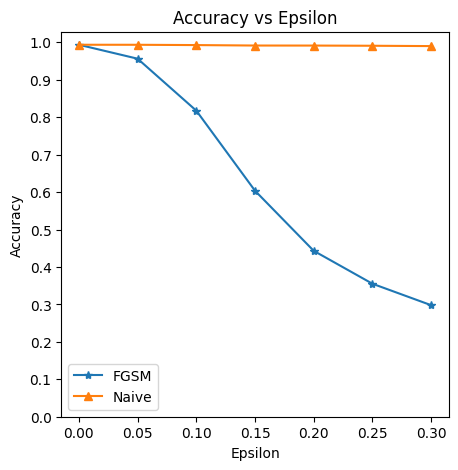

In [13]:
accuracies, bl_accuracies, examples = perform_exp(rmodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

While the network is completely resiliant to random noise, performance drastically decreases using the FGSM method. Notably, FGSM doesn't decrease performance to chance level anymore.

### *Experiment 3 - Generalization between different architectures*

#### Noise based on a simple network tested on a complex network

Epsilon:  0	FGSM	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0	Naive	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0.05	FGSM	Test Accuracy = 9883/10000 = 0.9883
Epsilon:  0.05	Naive	Test Accuracy = 9935/10000 = 0.9935
Epsilon:  0.1	FGSM	Test Accuracy = 9781/10000 = 0.9781
Epsilon:  0.1	Naive	Test Accuracy = 9927/10000 = 0.9927
Epsilon:  0.15	FGSM	Test Accuracy = 9524/10000 = 0.9524
Epsilon:  0.15	Naive	Test Accuracy = 9915/10000 = 0.9915
Epsilon:  0.2	FGSM	Test Accuracy = 8939/10000 = 0.8939
Epsilon:  0.2	Naive	Test Accuracy = 9914/10000 = 0.9914
Epsilon:  0.25	FGSM	Test Accuracy = 7679/10000 = 0.7679
Epsilon:  0.25	Naive	Test Accuracy = 9909/10000 = 0.9909
Epsilon:  0.3	FGSM	Test Accuracy = 5664/10000 = 0.5664
Epsilon:  0.3	Naive	Test Accuracy = 9900/10000 = 0.99


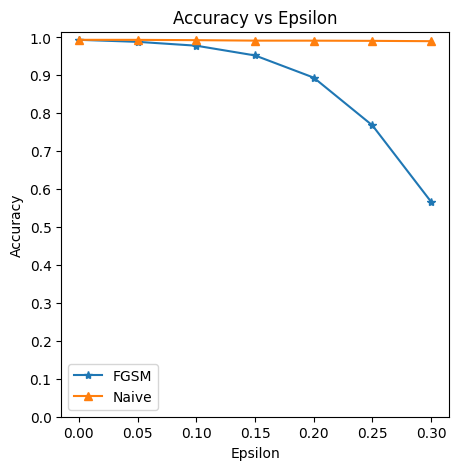

In [14]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, rmodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

#### Noise based on a complex network tested on a simple network

Epsilon:  0	FGSM	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0	Naive	Test Accuracy = 9884/10000 = 0.9884
Epsilon:  0.05	FGSM	Test Accuracy = 9749/10000 = 0.9749
Epsilon:  0.05	Naive	Test Accuracy = 9879/10000 = 0.9879
Epsilon:  0.1	FGSM	Test Accuracy = 9329/10000 = 0.9329
Epsilon:  0.1	Naive	Test Accuracy = 9858/10000 = 0.9858
Epsilon:  0.15	FGSM	Test Accuracy = 8474/10000 = 0.8474
Epsilon:  0.15	Naive	Test Accuracy = 9813/10000 = 0.9813
Epsilon:  0.2	FGSM	Test Accuracy = 7312/10000 = 0.7312
Epsilon:  0.2	Naive	Test Accuracy = 9690/10000 = 0.969
Epsilon:  0.25	FGSM	Test Accuracy = 6077/10000 = 0.6077
Epsilon:  0.25	Naive	Test Accuracy = 9441/10000 = 0.9441
Epsilon:  0.3	FGSM	Test Accuracy = 5015/10000 = 0.5015
Epsilon:  0.3	Naive	Test Accuracy = 8712/10000 = 0.8712


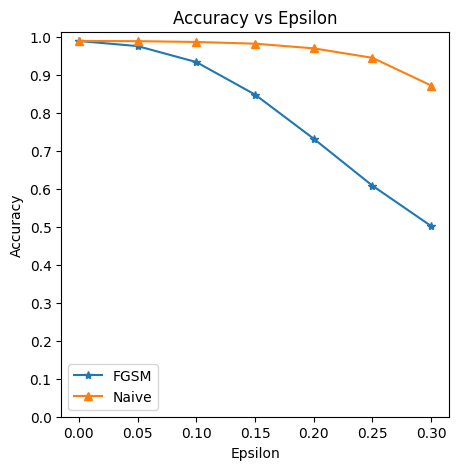

In [15]:
accuracies, bl_accuracies, examples = perform_exp(rmodel1, smodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

The FGSM method is considerably less efficient here when using a different architecture but still dramitaclly decreases performance with higher epsilon values.

### *Experiment 4 - Generaliztion between similar architectures B*

Repeating experiment 2 with the Resnets for completeness

In [16]:
# Load second resnet trained model
rmodel2 = Resnet().to(DEVICE)
rmodel2.load_state_dict(torch.load(RESNET_MODEL2))
_ = rmodel2.eval()

Epsilon:  0	FGSM	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0	Naive	Test Accuracy = 9936/10000 = 0.9936
Epsilon:  0.05	FGSM	Test Accuracy = 9797/10000 = 0.9797
Epsilon:  0.05	Naive	Test Accuracy = 9935/10000 = 0.9935
Epsilon:  0.1	FGSM	Test Accuracy = 9362/10000 = 0.9362
Epsilon:  0.1	Naive	Test Accuracy = 9927/10000 = 0.9927
Epsilon:  0.15	FGSM	Test Accuracy = 8199/10000 = 0.8199
Epsilon:  0.15	Naive	Test Accuracy = 9915/10000 = 0.9915
Epsilon:  0.2	FGSM	Test Accuracy = 6003/10000 = 0.6003
Epsilon:  0.2	Naive	Test Accuracy = 9914/10000 = 0.9914
Epsilon:  0.25	FGSM	Test Accuracy = 3922/10000 = 0.3922
Epsilon:  0.25	Naive	Test Accuracy = 9909/10000 = 0.9909
Epsilon:  0.3	FGSM	Test Accuracy = 2530/10000 = 0.253
Epsilon:  0.3	Naive	Test Accuracy = 9900/10000 = 0.99


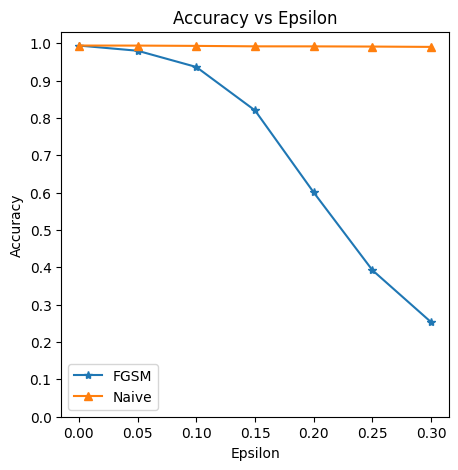

In [18]:
accuracies, bl_accuracies, examples = perform_exp(rmodel2, rmodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Results here are expected based on the combination of experiments 2 and 3.

### Adversarial training of deep networks

The following experiments aim at exploring the information under subsection "Adversarial training of deep networks" in the paper.

In the following segment, only simple models trained for 20 epochs were tested. This approach was chosen as both models types were shown to be affected by the FGSM, simple models being easier to train and analyze and the focus on effects rather than performance.

### *Experiment 5 - Training with adversarial regularization*

First the approach suggested in the paper is tested in which a regularization is added. This regularization is described in the equation:

J ̃(θ, x, y) = αJ(θ, x, y) + (1 − α)J(θ, x + εsign (∇xJ(θ, x, y).

In [47]:
regmodel1 = Net().to(DEVICE)
regmodel1.load_state_dict(torch.load(REG_MODEL1))
_ = regmodel1.eval()

Epsilon:  0	FGSM	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.05	FGSM	Test Accuracy = 9637/10000 = 0.9637
Epsilon:  0.05	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.1	FGSM	Test Accuracy = 9543/10000 = 0.9543
Epsilon:  0.1	Naive	Test Accuracy = 9870/10000 = 0.987
Epsilon:  0.15	FGSM	Test Accuracy = 9435/10000 = 0.9435
Epsilon:  0.15	Naive	Test Accuracy = 9868/10000 = 0.9868
Epsilon:  0.2	FGSM	Test Accuracy = 9232/10000 = 0.9232
Epsilon:  0.2	Naive	Test Accuracy = 9865/10000 = 0.9865
Epsilon:  0.25	FGSM	Test Accuracy = 8896/10000 = 0.8896
Epsilon:  0.25	Naive	Test Accuracy = 9860/10000 = 0.986
Epsilon:  0.3	FGSM	Test Accuracy = 8433/10000 = 0.8433
Epsilon:  0.3	Naive	Test Accuracy = 9843/10000 = 0.9843


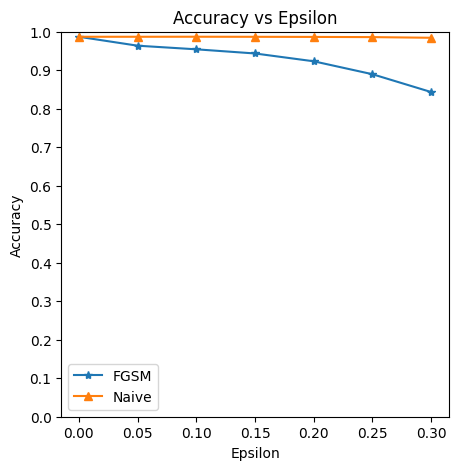

In [48]:
accuracies, bl_accuracies, examples = perform_exp(regmodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Epsilon:  0	FGSM	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.05	FGSM	Test Accuracy = 9758/10000 = 0.9758
Epsilon:  0.05	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.1	FGSM	Test Accuracy = 9678/10000 = 0.9678
Epsilon:  0.1	Naive	Test Accuracy = 9870/10000 = 0.987
Epsilon:  0.15	FGSM	Test Accuracy = 9578/10000 = 0.9578
Epsilon:  0.15	Naive	Test Accuracy = 9868/10000 = 0.9868
Epsilon:  0.2	FGSM	Test Accuracy = 9338/10000 = 0.9338
Epsilon:  0.2	Naive	Test Accuracy = 9865/10000 = 0.9865
Epsilon:  0.25	FGSM	Test Accuracy = 8459/10000 = 0.8459
Epsilon:  0.25	Naive	Test Accuracy = 9860/10000 = 0.986
Epsilon:  0.3	FGSM	Test Accuracy = 7237/10000 = 0.7237
Epsilon:  0.3	Naive	Test Accuracy = 9843/10000 = 0.9843


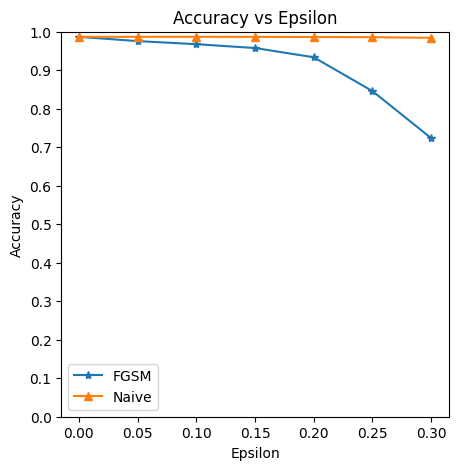

In [50]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, regmodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

The regularized model was proved to be much more resilient to noise generated using the FGSM and also completely resilient to random noise, proving the regularization efficient. Using a different model with a similar architecture to generate the noise the network is still more resilient than previously but falls short with noise stronger than that it was trained upon.

### *Experiment 6 - Training with adversarial examples from another model*

Here The model was trained with 30% of the images replaced with noisy images generated using the FGSM and smodel1. These examples didn't change during the learning process.

In [ ]:
# Load simple model trained with 30% of adversarial examples with epsilon of 0.2 based on smodel1
aemodel1 = Net().to(DEVICE)
aemodel1.load_state_dict(torch.load(AE_MODEL1))
_ = aemodel1.eval()

Epsilon:  0	FGSM	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0	Naive	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0.05	FGSM	Test Accuracy = 9933/10000 = 0.9933
Epsilon:  0.05	Naive	Test Accuracy = 9875/10000 = 0.9875
Epsilon:  0.1	FGSM	Test Accuracy = 9944/10000 = 0.9944
Epsilon:  0.1	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.15	FGSM	Test Accuracy = 9933/10000 = 0.9933
Epsilon:  0.15	Naive	Test Accuracy = 9861/10000 = 0.9861
Epsilon:  0.2	FGSM	Test Accuracy = 9921/10000 = 0.9921
Epsilon:  0.2	Naive	Test Accuracy = 9846/10000 = 0.9846
Epsilon:  0.25	FGSM	Test Accuracy = 9913/10000 = 0.9913
Epsilon:  0.25	Naive	Test Accuracy = 9800/10000 = 0.98
Epsilon:  0.3	FGSM	Test Accuracy = 9904/10000 = 0.9904
Epsilon:  0.3	Naive	Test Accuracy = 9755/10000 = 0.9755


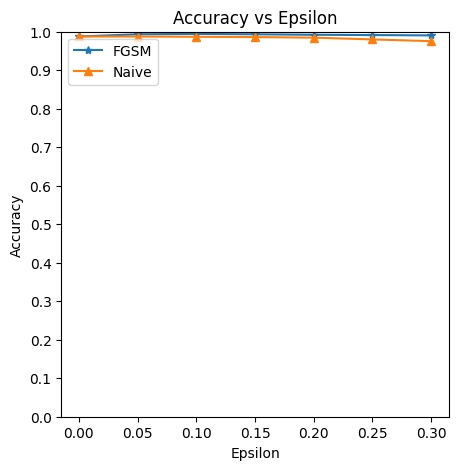

In [37]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, aemodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Expectadly, the new network is completely resilient to the noise from the smodel1, despite being different samples, it is still somewhat like testing on the training data.

Epsilon:  0	FGSM	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0	Naive	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0.05	FGSM	Test Accuracy = 9794/10000 = 0.9794
Epsilon:  0.05	Naive	Test Accuracy = 9875/10000 = 0.9875
Epsilon:  0.1	FGSM	Test Accuracy = 9671/10000 = 0.9671
Epsilon:  0.1	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.15	FGSM	Test Accuracy = 9411/10000 = 0.9411
Epsilon:  0.15	Naive	Test Accuracy = 9861/10000 = 0.9861
Epsilon:  0.2	FGSM	Test Accuracy = 8796/10000 = 0.8796
Epsilon:  0.2	Naive	Test Accuracy = 9846/10000 = 0.9846
Epsilon:  0.25	FGSM	Test Accuracy = 7553/10000 = 0.7553
Epsilon:  0.25	Naive	Test Accuracy = 9800/10000 = 0.98
Epsilon:  0.3	FGSM	Test Accuracy = 5969/10000 = 0.5969
Epsilon:  0.3	Naive	Test Accuracy = 9755/10000 = 0.9755


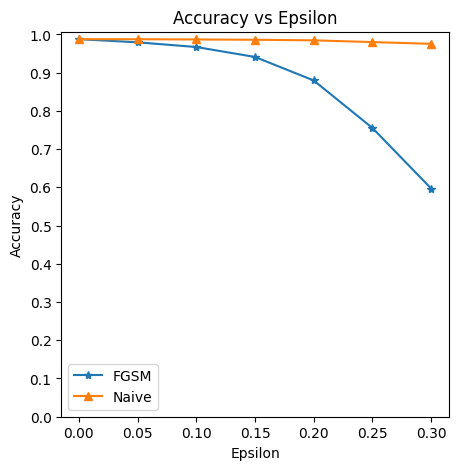

In [39]:
accuracies, bl_accuracies, examples = perform_exp(smodel2, aemodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

When generating the noise based on another network with a simiilar architecture, the new network proves to not be resilient anymore to noise from the FGSM.

Epsilon:  0	FGSM	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0	Naive	Test Accuracy = 9876/10000 = 0.9876
Epsilon:  0.05	FGSM	Test Accuracy = 7926/10000 = 0.7926
Epsilon:  0.05	Naive	Test Accuracy = 9875/10000 = 0.9875
Epsilon:  0.1	FGSM	Test Accuracy = 4480/10000 = 0.448
Epsilon:  0.1	Naive	Test Accuracy = 9869/10000 = 0.9869
Epsilon:  0.15	FGSM	Test Accuracy = 1891/10000 = 0.1891
Epsilon:  0.15	Naive	Test Accuracy = 9861/10000 = 0.9861
Epsilon:  0.2	FGSM	Test Accuracy = 678/10000 = 0.0678
Epsilon:  0.2	Naive	Test Accuracy = 9846/10000 = 0.9846
Epsilon:  0.25	FGSM	Test Accuracy = 276/10000 = 0.0276
Epsilon:  0.25	Naive	Test Accuracy = 9800/10000 = 0.98
Epsilon:  0.3	FGSM	Test Accuracy = 94/10000 = 0.0094
Epsilon:  0.3	Naive	Test Accuracy = 9755/10000 = 0.9755


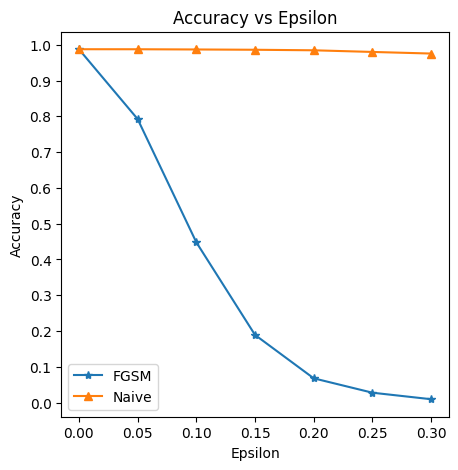

In [40]:
accuracies, bl_accuracies, examples = perform_exp(aemodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Using a white-box attack makes it even worse with the network failing miserably (even below chance for high epsilon values. The network still resists random noise better than earlier though.

### *Experiment 7 - Training with adversarial examples from the same network*

A simplified version of the regulariztion, requiring a bit less computations as the loss is calculated one time less (this may not be critical though). For every epoch, 30% of the samples were replaced with the perturbed images.

In [42]:
# Load simple model trained with 30% of adversarial examples with epsilon of 0.2 based on itself at each epoch
aermodel1 = Net().to(DEVICE)
aermodel1.load_state_dict(torch.load(AER_MODEL1))
_ = aermodel1.eval()

Epsilon:  0	FGSM	Test Accuracy = 9856/10000 = 0.9856
Epsilon:  0	Naive	Test Accuracy = 9856/10000 = 0.9856
Epsilon:  0.05	FGSM	Test Accuracy = 9784/10000 = 0.9784
Epsilon:  0.05	Naive	Test Accuracy = 9854/10000 = 0.9854
Epsilon:  0.1	FGSM	Test Accuracy = 9688/10000 = 0.9688
Epsilon:  0.1	Naive	Test Accuracy = 9846/10000 = 0.9846
Epsilon:  0.15	FGSM	Test Accuracy = 9536/10000 = 0.9536
Epsilon:  0.15	Naive	Test Accuracy = 9845/10000 = 0.9845
Epsilon:  0.2	FGSM	Test Accuracy = 9332/10000 = 0.9332
Epsilon:  0.2	Naive	Test Accuracy = 9829/10000 = 0.9829
Epsilon:  0.25	FGSM	Test Accuracy = 8961/10000 = 0.8961
Epsilon:  0.25	Naive	Test Accuracy = 9821/10000 = 0.9821
Epsilon:  0.3	FGSM	Test Accuracy = 8330/10000 = 0.833
Epsilon:  0.3	Naive	Test Accuracy = 9796/10000 = 0.9796


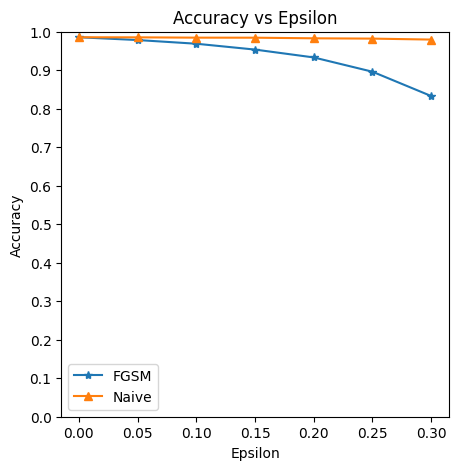

In [43]:
accuracies, bl_accuracies, examples = perform_exp(smodel1, aermodel1, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Epsilon:  0	FGSM	Test Accuracy = 9856/10000 = 0.9856
Epsilon:  0	Naive	Test Accuracy = 9856/10000 = 0.9856
Epsilon:  0.05	FGSM	Test Accuracy = 9681/10000 = 0.9681
Epsilon:  0.05	Naive	Test Accuracy = 9854/10000 = 0.9854
Epsilon:  0.1	FGSM	Test Accuracy = 9462/10000 = 0.9462
Epsilon:  0.1	Naive	Test Accuracy = 9846/10000 = 0.9846
Epsilon:  0.15	FGSM	Test Accuracy = 9168/10000 = 0.9168
Epsilon:  0.15	Naive	Test Accuracy = 9845/10000 = 0.9845
Epsilon:  0.2	FGSM	Test Accuracy = 8898/10000 = 0.8898
Epsilon:  0.2	Naive	Test Accuracy = 9829/10000 = 0.9829
Epsilon:  0.25	FGSM	Test Accuracy = 8568/10000 = 0.8568
Epsilon:  0.25	Naive	Test Accuracy = 9821/10000 = 0.9821
Epsilon:  0.3	FGSM	Test Accuracy = 8224/10000 = 0.8224
Epsilon:  0.3	Naive	Test Accuracy = 9796/10000 = 0.9796


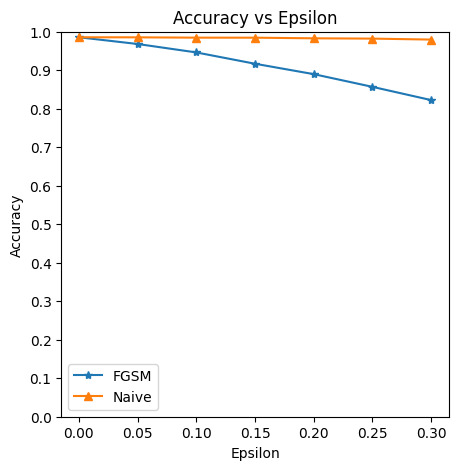

In [44]:
accuracies, bl_accuracies, examples = perform_exp(aermodel1, None, test_loader)
plot_acc_graph(accuracies, bl_accuracies)

Results seem comperable to the regularization method, and perhaps slighlty better but comparison without statistical power is impossible.

## Open questions:

1) In this notebook, The form of the errors and consistency across models wasn't tested.
2) Effects of different Alpha, P, and epsilon values on regularization in training with adversarial examples should be further tested.
3) Statistical conclusions should be tested when further computational power would be available.
4) Missing comparison to other transformation and augmentation methods.
5) More complex dataset.
6) Analysis of image properties with the noise (brightness/contrast/etc').